In [71]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import json
import matplotlib.pyplot as plt

In [63]:
device = torch.device('cuda:1')

# Data

In [32]:
data_dir = 'log'
dataset_json = 'dataset.json'
data_len = 1000

In [57]:
class ClothSimDataset(Dataset):
    """Simulated cloth parameters dataset."""

    def __init__(self, data_dir, dataset_json, flatten=False, transform=None):
        """
        Args:
            data_dir (string): Directory with all the data.
            data_len (int): Name of the json file with dataset information.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_dir = data_dir
        with open(os.path.join(data_dir, dataset_json)) as f:
            self.dataset = json.load(f)['dataset_paths']
        self.data_len = data_len
        self.flatten = flatten
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_dir = os.path.join(self.data_dir, str(self.dataset[idx]))
        cloth_points = np.load(os.path.join(sample_dir, 'cloth_points_transformed.npy'))
        parameters = np.load(os.path.join(sample_dir, 'parameters.npy'))        
        if self.flatten:
            cloth_points = cloth_points.flatten()

        sample = (cloth_points, parameters)
        if self.transform:
            sample = self.transform(sample)
        return sample

In [61]:
train_split = 0.8
train_length = int(train_split * data_len)
val_length = data_len - train_length
all_dataset = ClothSimDataset(data_dir, dataset_json, flatten=True)
train_dataset, val_dataset = torch.utils.data.random_split(all_dataset, [train_length, val_length])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True, num_workers=4)

In [62]:
for pts, params in train_loader:
    print(pts.shape)
    print(params.shape)
    break

torch.Size([32, 2000])
torch.Size([32, 6])


# Model

In [76]:
model = torch.nn.Sequential(
    torch.nn.Linear(2000, 2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 2 * 6),
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training

In [77]:
loss_fn = torch.nn.GaussianNLLLoss()
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(100):
    model.train()
    train_losses = []
    for position, target_params in train_loader:
        position = position.to(device).float()
        target_params = target_params.to(device).float()
        
        pred_params_mu, pred_params_logvar = torch.split(model(position), 6, dim=1)
        loss = loss_fn(pred_params_mu, target_params, torch.exp(pred_params_logvar))
        
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_losses = []
        for position, target_params in val_loader:
            position = position.to(device).float()
            target_params = target_params.to(device).float()

            pred_params_mu, pred_params_logvar = torch.split(model(position), 6, dim=1)
            loss = loss_fn(pred_params_mu, target_params, torch.exp(pred_params_logvar))

            val_losses.append(loss.item())

    print("Epoch: {}, Train Loss: {}, Val Loss: {}".format(epoch, np.mean(train_losses), np.mean(val_losses)))
    epoch_train_losses.append(np.mean(train_losses))
    epoch_val_losses.append(np.mean(val_losses))

Epoch: 0, Train Loss: 6.78854573726654, Val Loss: 1.2717344079698836
Epoch: 1, Train Loss: 1.3097222805023194, Val Loss: 0.9461366534233093
Epoch: 2, Train Loss: 0.7723245048522949, Val Loss: 0.5649421215057373
Epoch: 3, Train Loss: 0.5766519677639007, Val Loss: 0.41651818581989836
Epoch: 4, Train Loss: 0.4748768067359924, Val Loss: 0.3726677681718554
Epoch: 5, Train Loss: 0.46304184556007383, Val Loss: 0.4518387232507978
Epoch: 6, Train Loss: 0.4327110457420349, Val Loss: 0.34234038421085905
Epoch: 7, Train Loss: 0.4104012632369995, Val Loss: 0.3545347877911159
Epoch: 8, Train Loss: 0.3900012767314911, Val Loss: 0.31330370903015137
Epoch: 9, Train Loss: 0.37954914808273316, Val Loss: 0.3795960077217647
Epoch: 10, Train Loss: 0.3795123207569122, Val Loss: 0.3781644744532449
Epoch: 11, Train Loss: 0.35054789781570433, Val Loss: 0.28288582818848745
Epoch: 12, Train Loss: 0.2972546797990799, Val Loss: 0.5055212123053414
Epoch: 13, Train Loss: 0.816489783525467, Val Loss: 0.457627181495939

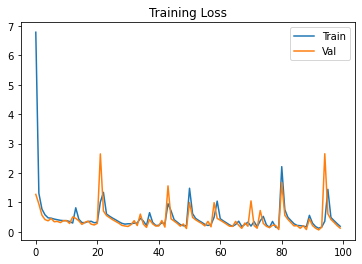

In [78]:
plt.plot(epoch_train_losses)
plt.plot(epoch_val_losses)
plt.legend(["Train", "Val"])
plt.title("Training Loss")
plt.show()